In [1]:
from diffusion import MnistDataset, unet
import torch
import os
from tqdm import tqdm
import torchvision

In [2]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def revimg(img):
    return (img * -1)

In [4]:
im = MnistDataset('train', im_path="../data/test/images").__getitem__(0)

100%|██████████| 10/10 [00:00<00:00, 469.29it/s]


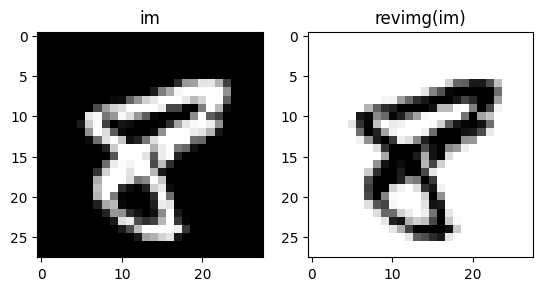

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im[0], cmap='gray')
axs[0].set_title('im')
axs[1].imshow(revimg(im[0]),cmap='gray')
axs[1].set_title('revimg(im)')
plt.show()

In [6]:
STEPS = 1000

In [7]:
# Create the noise scheduler
from diffusion import NoiseScheduler


scheduler = NoiseScheduler( noise_start=0.00001,
                            noise_end=0.02,
                            steps=STEPS)


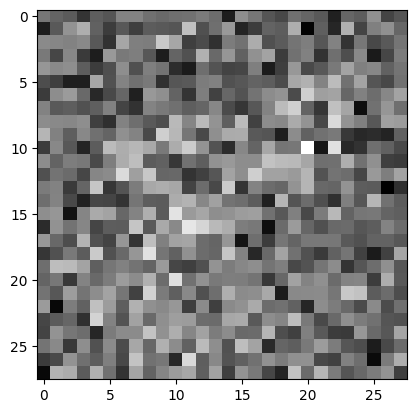

In [8]:
# Sample random noise from Z ... 
noise = torch.randn_like(im)

t = 400 - 1#noise to the last step

# Add noise to images according to timestep
noisy_im = scheduler.add_noise(im, noise, t)

plt.imshow(noisy_im[0],cmap='gray')
plt.show()

In [9]:
! pwd

/home/maiku/Desktop/DMAD-DDPM/Direct_Diffusion


In [10]:
model = unet(1)
model.load_state_dict(torch.load(os.path.join("out",
                                              "m1.pth")))
model.eval()
model = model.to(device)

In [11]:
noisy_im.unsqueeze(0).size()

torch.Size([1, 1, 28, 28])

399it [00:20, 19.42it/s]


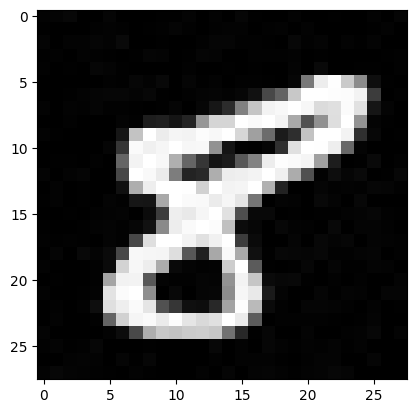

In [12]:
# make it 1 x 1 x 28 x 28
xt = noisy_im.unsqueeze(0).to(device)

scheduler.to(device)

for i in tqdm(reversed(range(t))):
    # Get prediction of noise
    noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
    
    # Use scheduler to get x0 and xt-1
    xt, _ = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i))
        
    #if i % 100 == 0:   # Save x0
    #    ims = torch.clamp(xt, -1., 1.).detach().cpu()
    #    ims = (ims + 1) / 2
    #    img = torchvision.transforms.ToPILImage()(ims[0])
    #    if not os.path.exists(os.path.join("out", 'denoise')):
    #        os.mkdir(os.path.join("out", 'denoise'))
    #    img.save(os.path.join("out", 'denoise', 'x0_{}.png'.format(i)))

im_out = torch.clamp(xt, -1., 1.).detach().cpu()
img = (im_out + 1) / 2
img = torchvision.transforms.ToPILImage()(img[0])
plt.imshow(img,cmap='gray')
plt.show()

torch.cuda.empty_cache()

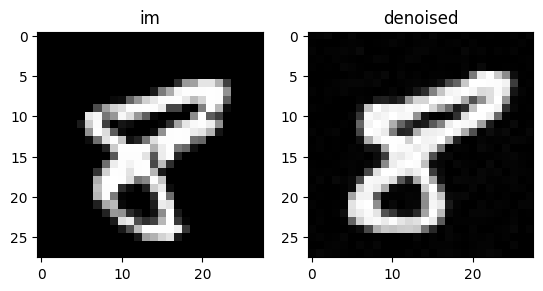

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im[0], cmap='gray')
axs[0].set_title('im')
axs[1].imshow(img,cmap='gray')
axs[1].set_title('denoised')
plt.show()

In [14]:
# n = torch.randn((1,1,28,28))
# for i in tqdm(reversed(range(STEPS))):
#     # Get prediction of noise
#     noise_pred = model(n, torch.as_tensor(i).unsqueeze(0))
#     
#     # Use scheduler to get x0 and xt-1
#     n, x0_pred = scheduler.sample_prev_timestep(n, noise_pred, torch.as_tensor(i))
# 
# torch.cuda.empty_cache()

In [15]:
# from matplotlib import pyplot as plt
# 
# img = torchvision.transforms.ToPILImage()(n.squeeze(0))
# plt.imshow(img,cmap='gray')
# plt.show()